In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load Data

In [2]:
X, y = load_iris(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
22,4.6,3.6,1.0,0.2
15,5.7,4.4,1.5,0.4
65,6.7,3.1,4.4,1.4
11,4.8,3.4,1.6,0.2
42,4.4,3.2,1.3,0.2


# Reduce to 2D

In [3]:
N_COMPONENTS = 2

pca = PCA(n_components=N_COMPONENTS, random_state=42)
# Transform features using PCA
X_train = pd.DataFrame(pca.fit_transform(X=X_train), columns=[f"PC{i+1}" for i in range(N_COMPONENTS)], index=X_train.index)
# Same for Test Set
X_test = pd.DataFrame(pca.transform(X=X_test), columns=[f"PC{i+1}" for i in range(N_COMPONENTS)], index=X_test.index)

## Visualize

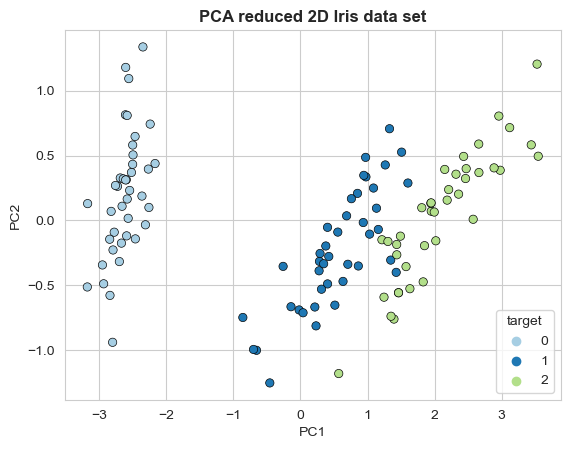

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_title("PCA reduced 2D Iris data set", fontweight="bold")
sns.scatterplot(data=X_train, x="PC1", y="PC2", hue=y_train, palette="Paired", edgecolor="black", ax=ax)
plt.show()

# Generative Model: Naive Bayes

In [5]:
def mvn_pdf(x: np.ndarray, mu: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    """
    Density of the Multivariate Normal Distribution
    :param x: samples, shape: [N x dimension]
    :param mu: mean, shape: [dimension]
    :param sigma: covariance, shape: [dimension x dimension]
    :return p(x) with p(x) = N(mu, sigma) , shape: [N]
    """
    norm_term = 1 / np.sqrt(np.linalg.det(2 * np.pi * sigma))
    diff = x - np.atleast_2d(mu)
    exp_term = np.sum(np.linalg.solve(sigma, diff.T).T * diff, axis=-1)
    return norm_term * np.exp(-0.5 * exp_term)

def mvn_mle(x: np.ndarray):
    """
    Maximum Likelihood Estimation of parameters for Multivariate Normal Distribution
    :param x: samples shape: [N x dimension]
    :return mean (shape: [dimension]) und covariance (shape: [dimension x dimension]) that maximize likelihood of data
    """
    mean = 1 / x.shape[0] * np.sum(x, axis=0)
    diff = x - mean
    cov = 1 / x.shape[0] * diff.T @ diff
    return mean, cov

def compute_posterior(samples: np.ndarray, p_c: float, mu: np.ndarray, sigma: np.ndarray):
    """
    computes the posteroir distribution p(c|x) given samples x, the prior p(c) and the
    class conditional likelihood p(x|c)
    :param samples: samples x to classify, shape: [N x dimension]
    :param p_c: prior probability of class c, p(c=0)
    :param mu: mean of class conditional likelihood of class c, p(x|c=c) shape: [dimension]
    :param sigma_c: covariance of class conditional likelihood of class c, p(x|c=c) shape: [dimension x dimension]
    """
    # TODO: compute class likelihoods, i.e. p(x|c)
    likelihood = mvn_pdf(x=samples, mu=mu, sigma=sigma)
    mu, sigma = mvn_mle(samples)
    p_x = mvn_pdf(x=samples, mu=mu, sigma=sigma)
    p_c_given_x = (likelihood * p_c) / p_x
    return p_c_given_x


In [6]:
# Get samples from each class
X_y_master = X_train.join(y_train)
# Put back to np.array and drop target column
c0_samples = np.array(X_y_master[X_y_master["target"] == 0].drop(columns="target"))
c1_samples = np.array(X_y_master[X_y_master["target"] == 1].drop(columns="target"))
c2_samples = np.array(X_y_master[X_y_master["target"] == 2].drop(columns="target"))

In [7]:
# Fit Gaussian Distributions using the maximum likelihood estimator to samples from both classes mu_c0, sigma_c0 = mvn_mle(c0_samples)
mu_c0, sigma_c0 = mvn_mle(c0_samples)
mu_c1, sigma_c1 = mvn_mle(c1_samples)
mu_c2, sigma_c2 = mvn_mle(c2_samples)
mu_mle = [mu_c0, mu_c1, mu_c2]

# Prior obtained by "counting" samples in each class
p_c0 = c0_samples.shape[0] / X_train.shape[0]
p_c1 = c1_samples.shape[0] / X_train.shape[0]
p_c2 = c2_samples.shape[0] / X_train.shape[0]

# Get posterior for test set with fitted ML parameters
p_c0_given_x = compute_posterior(X_test.values, p_c0, mu_c0, sigma_c0)
p_c1_given_x = compute_posterior(X_test.values, p_c1, mu_c1, sigma_c1)
p_c2_given_x = compute_posterior(X_test.values, p_c2, mu_c1, sigma_c2)

In [8]:
posterior_df = pd.DataFrame({
    "P(c=0|x)": p_c0_given_x,
    "P(c=1|x)": p_c1_given_x,
    "P(c=2|x)": p_c2_given_x,
}, index=X_test.index)

In [9]:
# Get prediction
y_pred = np.argmax(posterior_df.values, axis=1)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.6333


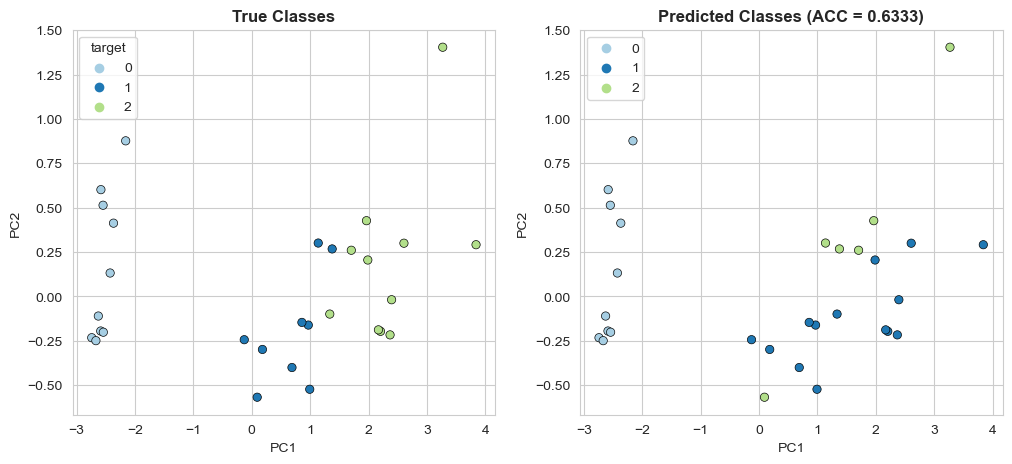

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
axes[0].set_title("True Classes", fontweight="bold")
axes[1].set_title(f"Predicted Classes (ACC = {acc:.4f})", fontweight="bold")
sns.scatterplot(data=X_test, x="PC1", y="PC2", hue=y_test, palette="Paired", edgecolor="black", ax=axes[0])
sns.scatterplot(data=X_test, x="PC1", y="PC2", hue=y_pred, palette="Paired", edgecolor="black", ax=axes[1])
plt.show()